# Tap Water Quality Forecasting

## Import

### Libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import SimpleRNN, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

### Dataset

In [2]:
filepath = "../../gecco_2019_drinking_water_quality_dataset.csv"
raw_df = pd.read_csv(
    filepath,
    parse_dates=["Time"],
    index_col="Time",
    usecols=["Time", "pH", "Turb"],
)
raw_df.head()

,pH,Turb
Time,,
2017-07-01 00:00:00,8.60774,0.125931
2017-07-01 00:01:00,8.60589,0.127219
2017-07-01 00:02:00,8.60220,0.126482
2017-07-01 00:03:00,8.60220,0.126184
2017-07-01 00:04:00,8.60405,0.127908


## Preprocessing

### Descriptive Analysis

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132480 entries, 2017-07-01 00:00:00 to 2017-09-30 23:59:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pH      132272 non-null  float64
 1   Turb    132275 non-null  float64
dtypes: float64(2)
memory usage: 3.0 MB


In [4]:
raw_df.describe()

,pH,Turb
count,132272.000000,132275.000000
mean,8.533168,0.128368
std,0.052646,0.005928
min,0.000000,0.000000
25%,8.502780,0.127160
50%,8.539630,0.127754
75%,8.563490,0.128686
max,8.666760,1.782850


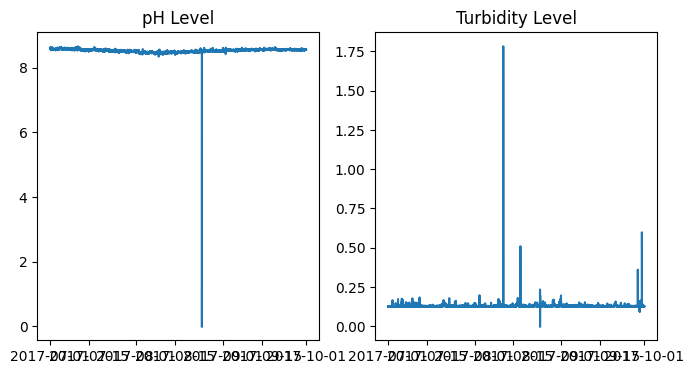

In [5]:
ph = raw_df['pH']
tb = raw_df['Turb']


def line_plot(param, param1):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].plot(param)
    axes[0].set_title('pH Level')

    axes[1].plot(param1)  # Example: Plotting the same data with a different color
    axes[1].set_title('Turbidity Level')

    plt.show()


line_plot(ph, tb)

In [6]:
raw_df.isnull().sum()

pH      208
Turb    205
dtype: int64

In [7]:
interpolated_df = raw_df.interpolate(method='time')

In [8]:
interpolated_df.isnull().sum()

pH      0
Turb    0
dtype: int64

### Treating Outliers

In [9]:
# IQR method
Q1 = interpolated_df["pH"].quantile(0.25)
Q3 = interpolated_df["pH"].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Detect outliers using the IQR
outliers = (interpolated_df["pH"] < lower) | (interpolated_df["pH"] > upper)

# Remove the outliers
removed_ph_outliers_df = interpolated_df[~outliers]
no_outliers_df = removed_ph_outliers_df[removed_ph_outliers_df["Turb"] <= 1]

no_outliers_df.describe()

,pH,Turb
count,132360.000000,132360.000000
mean,8.533367,0.128357
std,0.040690,0.003767
min,8.411880,0.094232
25%,8.502780,0.127160
50%,8.539710,0.127753
75%,8.563490,0.128685
max,8.653850,0.784440


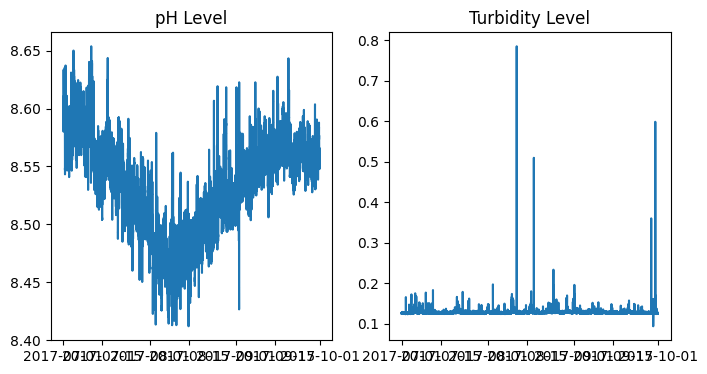

In [10]:
line_plot(no_outliers_df['pH'], no_outliers_df['Turb'])

In [11]:
# no_outliers_df.set_index("Time", inplace=True)
hourly_df = no_outliers_df.resample("H").mean()
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2017-07-01 00:00:00 to 2017-09-30 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pH      2208 non-null   float64
 1   Turb    2208 non-null   float64
dtypes: float64(2)
memory usage: 51.8 KB


In [12]:
final_df = hourly_df

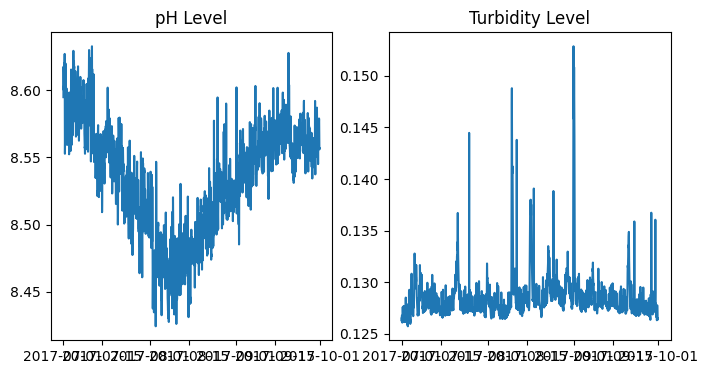

In [13]:
line_plot(final_df['pH'], final_df['Turb'])

## Preparation

### Train and test split

In [14]:
train_size = int(0.8 * len(final_df))
train = final_df[:train_size]
test = final_df[train_size:]

### Scaling

In [15]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Split

In [16]:
def split_multivariate_sequence(data, input_steps, output_steps):
    X, y = list(), list()

    for i in range(len(data)):
        # Find the end of the input sequence
        input_end_idx = i + input_steps
        output_end_idx = input_end_idx + output_steps

        # Check if we are beyond the dataset
        if output_end_idx > len(data):
            break

        # Gather input and output parts of the sequence
        input_seq, output_seq = data[i:input_end_idx, :], data[input_end_idx:output_end_idx, :]
        X.append(input_seq)
        y.append(output_seq)

    return np.array(X), np.array(y)

In [17]:
# choose a number of time steps
n_steps_in, n_steps_out = 1, 1
# covert into input/output
X_train, y_train = split_multivariate_sequence(train_scaled, n_steps_in, n_steps_out)
print(f'X Train: {X_train.shape} \nY Train: {y_train.shape}')

X_test, y_test = split_multivariate_sequence(test_scaled, n_steps_in, n_steps_out)
print(f'X Test: {X_test.shape}\nY Test: {y_test.shape}')

X Train: (1765, 1, 2) 
Y Train: (1765, 1, 2)
X Test: (441, 1, 2)
Y Test: (441, 1, 2)


## Modeling

### Defining Model

In [18]:
n_features = X_train.shape[2]

In [19]:
# define model
model = Sequential()
model.add(
    SimpleRNN(
        128,
        activation="relu",
        bias_regularizer=l2(0.01),
        kernel_regularizer=l2(0.01),
        recurrent_regularizer=l2(0.01),
        input_shape=(n_steps_in, n_features),
    )
)

model.add(Dropout(0.2))

model.add(Dense(n_features))

model.compile(optimizer="adam", loss="mse")

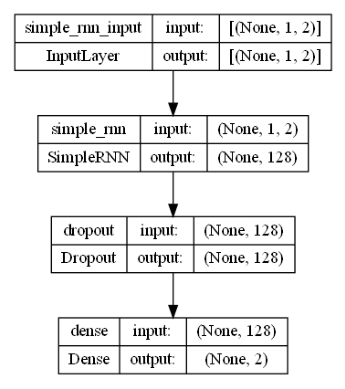

In [20]:
# Plot the model architecture
from keras.utils import plot_model

plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot
image = plt.imread(plot_file)
plt.imshow(image)
plt.axis('off')
plt.show()

### Fitting Model

In [21]:
# Early stopping based on validation loss
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=2)

# Reduce learning rate based on validation loss
reduce_lr_val_loss = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [22]:
# Use these callbacks during model training
history = model.fit(X_train, y_train, epochs=10000,
                    callbacks=[early_stopping_val_loss, reduce_lr_val_loss],
                    validation_split=0.1, batch_size=512)

Epoch 1/10000
4/4 [==============================] - 3s 96ms/step - loss: 1.4541 - val_loss: 1.4262 - lr: 0.0010
Epoch 2/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.3376 - val_loss: 1.3020 - lr: 0.0010
Epoch 3/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.2277 - val_loss: 1.1882 - lr: 0.0010
Epoch 4/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1281 - val_loss: 1.0846 - lr: 0.0010
Epoch 5/10000
4/4 [==============================] - 0s 17ms/step - loss: 1.0373 - val_loss: 0.9907 - lr: 0.0010
Epoch 6/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9550 - val_loss: 0.9062 - lr: 0.0010
Epoch 7/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8809 - val_loss: 0.8303 - lr: 0.0010
Epoch 8/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8144 - val_loss: 0.7628 - lr: 0.0010
Epoch 9/10000
4/4 [==============================] - 0s 17ms/step - loss: 0.7550 - val_loss: 0.7